## **Section 1:**

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import time

def initialize_parameters(layer_dims):
    """
    Initialize parameters (W and b) for each layer in the neural network.

    Args:
        layer_dims (list): an array of the dimensions of each layer in the network
            (layer 0 is the size of the flattened input, layer L is the output softmax).

    Returns:
        dict: a dictionary containing the initialized W and b parameters of each layer (W1…WL, b1…bL).
    """
    parameters = {}
    prev_size = layer_dims[0]

    for l, l_size in enumerate(layer_dims[1:], start=1):

        # Initialize weights W using random values from a standard normal distribution
        W = np.random.randn(l_size, prev_size)

        # Initialize bias b with zeros
        b = np.zeros((l_size, 1))

        # Store the parameters in the dictionary
        parameters[f'W{l}'] = W
        parameters[f'b{l}'] = b

        prev_size = l_size

    return parameters

In [23]:
def linear_forward(A, W, b):
    """
    Compute the linear forward pass.

    Args:
    A (numpy array): Input activation from the previous layer.
    W (numpy array): Weight matrix.
    b (numpy array): Bias vector.

    Returns:
    Z (numpy array): Linear output.
    cache (tuple): Tuple containing the input activation A, weight matrix W, and bias vector b.
    """
    # Compute the linear output Z
    Z = W @ A + b
    # Cache the input activation A, weight matrix W, and bias vector b for later use in backpropagation
    cache = (A, W, b)
    return Z, cache

In [24]:
def softmax(Z):
    """
    Compute the softmax activation for the input Z.

    Args:
    Z (numpy array): Input to the softmax function.

    Returns:
    A (numpy array): Output of the softmax function.
    activation_cache (numpy array): Cache the input Z for later use in backpropagation.
    """
    # Compute the numerator by exponentiating each element of Z
    numerator = np.exp(Z)
    # Compute the denominator by summing up the exponentiated values
    denominator = np.sum(numerator, axis=0)
    # Compute the softmax output by dividing each element of the numerator by the denominator
    A = numerator / denominator
    # Cache the input Z for later use in backpropagation
    activation_cache = Z

    return A, activation_cache

In [25]:
def relu(Z):
    """
    Compute the ReLU activation.

    Args:
    Z (numpy array): Input to the ReLU activation.

    Returns:
    A (numpy array): Output of the ReLU activation.
    activation_cache (numpy array): Cache the input Z for later use in backpropagation.
    """
    # Apply the element-wise ReLU activation function
    A = np.maximum(Z, 0)
    # Cache the input Z for later use in backpropagation
    activation_cache = Z

    return A, activation_cache

In [26]:
def linear_activation_forward(A_prev, W, B, activation):
    """
    Input:
        A_prev - activations of the previous layer
        W - the weights matrix of the current layer
        B - the bias vector of the current layer
        Activation - the activation function to be used (a string, either “softmax” or “relu”)

    Output:
        A - the activations of the current layer
        cache - a joint dictionary containing both linear_cache and activation_cache
    """
    cache = {}

    # Perform the linear transformation
    Z, linear_cache = linear_forward(A_prev, W, B)

    # Apply the specified activation function
    if activation == "softmax":
        A, activation_cache = softmax(Z)
    else:
        A, activation_cache = relu(Z)

    # Cache the linear and activation information for later use in backpropagation
    cache["linear_cache"] = linear_cache
    cache["activation_cache"] = activation_cache
    return A, cache

In [27]:
def L_model_forward(X, parameters, use_batchnorm=False):
    """
    Input:
        X - the data, numpy array of shape (input size, number of examples)
        parameters - the initialized W and b parameters of each layer
        use_batchnorm - a boolean flag used to determine whether to apply batchnorm after the activation (note that this option needs to be set to “false” in Section 3 and “true” in Section 4).

    Output:
        AL - the last post-activation value
        caches - a list of all the cache objects generated by the linear_forward function
    """
    AL = X
    L = len(parameters)//2
    cache_list = []

    for layer in range(1, L + 1):
        W = parameters[f'W{layer}']
        b = parameters[f'b{layer}']
        activation = "relu" if layer < L else "softmax"

        # Linear activation forward
        AL, caches = linear_activation_forward(AL, W, b, activation)
        cache_list.append(caches)

        # Apply batch normalization if specified and the activation is ReLU
        if use_batchnorm and activation == "relu":
            AL = apply_batchnorm(AL)
    return AL, cache_list

In [28]:
def compute_cost(AL, Y, params, r=0):
    """
    Input:
        AL - the output of the neural network, shape (number of classes, number of examples)
        Y - the actual labels, shape (number of classes, number of examples)
        params - a dictionary containing the weight and bias parameters of each layer
        r - regularization parameter (lambda) for L2 regularization

    Output:
        cost - the computed cost (cross-entropy loss + L2 regularization term)
    """
    log_AL = np.log(AL)  # Compute the log of the predicted probabilities
    shape_y_hat = log_AL.shape[1]  # Number of examples

    # Compute the cross-entropy loss
    mul_sum = np.sum(Y * log_AL, axis=0)
    cross_entropy_loss = -np.sum(mul_sum) / shape_y_hat

    # Penalty of the model
    l2 = 0
    for key, val in params.items():
      if key.startswith('W'):  # Check if the key corresponds to a weight matrix
        l2 += np.sum(np.square(val))

    l2*= (r / (2 * shape_y_hat))  # Factor of 1/2m is included in the regularization term

    return cross_entropy_loss + l2

In [29]:
def apply_batchnorm(A):
    """
    Apply batch normalization to the input activation A.

    Args:
    A (numpy array): Input activation.

    Returns:
    NA (numpy array): Normalized activation.
    """
    # Compute mean and variance of the activation
    A_mean = np.mean(A)
    var = np.mean((A - A_mean) ** 2)

    # Normalize the activation
    NA = (A - A_mean) / ((var + 1e-6) ** (1 / 2))

    return NA

##**Section 2:**

In [30]:
def Linear_backward(dZ, cache, r=0):
    """
    Implements the linear part of the backward propagation process for a single layer.

    Input:
    dZ -- the gradient of the cost with respect to the linear output of the current layer (layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Output:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A, W, b = cache
    shape_Z = dZ.shape[1]

    # Compute gradients
    dW = (1 / shape_Z) * np.matmul(dZ, A.T) + (r / shape_Z) * W
    db = (1 / shape_Z) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.matmul(W.T, dZ)

    return dA_prev, dW, db

In [31]:
def linear_activation_backward(dA, cache, activation, r=0):
    if activation == "softmax":
        dZ = softmax_backward(dA, cache["Y_cache"])
    else:
        dZ = relu_backward(dA, cache["activation_cache"])
    dA_prev, dW, db = Linear_backward(dZ, cache["linear_cache"], r)
    return dA_prev, dW, db

In [32]:
def relu_backward(dA, activation_cache):
    drelu = np.where(activation_cache > np.zeros_like(activation_cache), np.ones_like(activation_cache), np.zeros_like(activation_cache))
    dZ = dA * drelu
    return dZ

In [33]:
def softmax_backward(dA, activation_cache):
  """
  dA-A
  activation_cache-Y
  """
  dZ = dA - activation_cache
  return dZ

In [34]:
def L_model_backward(AL, Y, caches, r=0):
    layer_num = len(caches)
    grads = {}
    for i, c_layer in enumerate(caches[::-1]):
        activation = "relu" if i != 0 else "softmax"
        if i == 0:
            c_layer["Y_cache"] = Y
            curr_layer = AL
        else:
            curr_layer = grads[f"dA{layer_num - i + 1}"]
        dA_prev, dW, db = linear_activation_backward(curr_layer, c_layer, activation, r)

        grads[f"dA{layer_num - i}"] = dA_prev
        grads[f"dW{layer_num - i}"] = dW
        grads[f"db{layer_num - i}"] = db

    return grads

In [35]:
def Update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent.

    Args:
    parameters (dict): A dictionary containing the DNN architecture's parameters.
    grads (dict): A dictionary containing the gradients generated by L_model_backward.
    learning_rate (float): The learning rate used to update the parameters.

    Returns:
    parameters (dict): The updated values of the parameters object provided as input.
    """
    for key in list(parameters.keys())[::-1]:
        if key.startswith("W"):
            layer_num = key[1:]
            parameters[key] -= learning_rate * grads[f"dW{layer_num}"]
        elif key.startswith("b"):
            layer_num = key[1:]
            parameters[key] -= learning_rate * grads[f"db{layer_num}"]

    return parameters


##**Section 3:**

In [36]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm=False, r=0):
    training_costs = []
    iteration_count = 0
    x_train, x_test, y_train, y_test = train_test_split(X.T, Y.T, test_size=0.20, random_state=42)
    x_train, x_val, y_train, y_val = x_train.T, x_test.T, y_train.T, y_test.T

    input_size = x_train.shape[0]
    size = x_train.shape[1]
    parameters = initialize_parameters(layer_dims= [input_size] + list(layers_dims))

    test_costs = []
    stop_training = False
    epochs = 0
    for _ in range(1, num_iterations + 1):
        if stop_training:
            break
        epochs += 1
        start_idx = 0
        end_idx = batch_size
        while start_idx < size:
            iteration_count += 1
            mini_batch_X = x_train[:, start_idx:end_idx]
            mini_batch_Y = y_train[:, start_idx:end_idx]
            AL, cache_list = L_model_forward(mini_batch_X, parameters, use_batchnorm)

            if iteration_count % 100 == 0:
                training_costs.append(compute_cost(AL, mini_batch_Y, parameters, r))

            grads = L_model_backward(AL, mini_batch_Y, cache_list, r)
            parameters = Update_parameters(parameters, grads, learning_rate=learning_rate)

            if iteration_count % 100 == 0:
                AL_val, _ = L_model_forward(x_val, parameters, use_batchnorm)
                test_costs.append(compute_cost(AL_val, y_val, parameters, r))
                if len(test_costs) > 1 and abs(test_costs[-1] - test_costs[-2]) <= 1e-5:
                    stop_training = True
                    break
            start_idx += batch_size
            end_idx += batch_size

    print(f"Iterations: {iteration_count}")
    print(f"Epochs: {epochs}")
    print()
    print("Train accuracy:")
    print(Predict(x_train, y_train, parameters, use_batchnorm))
    print()
    print("Validation accuracy:")
    print(Predict(x_val, y_val, parameters, use_batchnorm))
    print()

    plt.plot(np.arange(0, iteration_count, step=100), training_costs, label='Training Set', color='blue')
    plt.plot(np.arange(0, iteration_count, step=100), test_costs, label='Validation Set', color='red')
    plt.title('Categorical Cross-Entropy Loss Cost')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()

    return parameters, training_costs

In [37]:
def Predict(X, Y, parameters, use_batchnorm=False):
    """
    Predict the accuracy of the trained neural network on the given data.

    Args:
    X (numpy array): The input data, shape (height * width, number_of_examples).
    Y (numpy array): The true labels of the data, shape (num_of_classes, number of examples).
    parameters (dict): A dictionary containing the DNN architecture's parameters.
    use_batchnorm (bool): A boolean flag indicating whether to use batch normalization.

    Returns:
    accuracy (float): The accuracy measure of the neural network on the provided data.
    """
    data_shape = X.shape[1]
    AL, _ = L_model_forward(X, parameters, use_batchnorm)
    predictions = np.argmax(AL, axis=0)
    true_labels = np.argmax(Y, axis=0)
    correct_predictions = np.sum(predictions == true_labels)
    accuracy = correct_predictions / data_shape

    return accuracy


##**Section 4:**

In [38]:
def preprocess_data(train_x, test_x, train_y, test_y):
    """Transform x and y to (784, m) and (10, m) respectively and normalize x.

    Args:
        train_x (np.array): x matrix for train
        test_x (np.array): x matrix for test
        train_y (np.array): y matrix for train
        test_y (np.array): y matrix for test

    Returns:
        tuple(np.array, np.array, np.array, np.array): x and y matrices for train and test to use in the model
    """
    size_train = len(train_x)
    size_test = len(test_x)

    # Normalize and flatten x matrices
    train_x = train_x.flatten().reshape(size_train, -1) / 255
    test_x = test_x.flatten().reshape(size_test, -1) / 255

    # Convert y matrices to one-hot encoding
    y_train = np.eye(10)[train_y]
    y_test = np.eye(10)[test_y]

    # Transpose matrices
    train_x, test_x, y_train, y_test = train_x.T, test_x.T, y_train.T, y_test.T

    return train_x, test_x, y_train, y_test


def Neural_Network(train_X, test_X, train_y, test_y, use_batchnorm=False,seed=None, r=0):
    """Main function for running experiments

    Args:
        train_X (np.array): train set of x data
        test_X (np.array): test set of x data
        train_y (np.array): train set of y data
        test_y (np.array): test set of y data
        use_batchnorm (bool, optional): determines whether training and testing the model should use batchnorm or not. Defaults to False.
        seed (int, optional): determines seed for experiment. Defaults to None.
        l (float, optional): regularization param. Defaults to 0.
    """
    if seed is not None:
        np.random.seed(seed)
    t = time.time()
    param, training_costs = L_layer_model(train_X, train_y, [20, 7, 5, 10], 0.009, 300, 64, use_batchnorm, r)
    print(f"Time: {(time.time() - t)}")
    print(f"Test accuracy:")
    print(Predict(test_X, test_y, param, use_batchnorm))

def batch_size(train_X, test_X, train_y, test_y, use_batchnorm=False,seed=None):
    """Find batch size that is optimal in accordance to test set accuracy

    Args:
        train_X (np.array): train set of x data
        test_X (np.array): test set of x data
        train_y (np.array): train set of y data
        test_y (np.array): test set of y data
        use_batchnorm (bool, optional): determines whether training and testing the model should use batchnorm or not. Defaults to False.
        seed (int, optional): determines seed for experiment. Defaults to None.
    """
    accuracy_list = []
    for batch_size in [32, 64, 128, 256, 512, 1024]:
        if seed is not None:
          np.random.seed(seed)
        param, training_costs = L_layer_model(train_X, train_y, [20, 7, 5, 10], 0.009, 300, batch_size, use_batchnorm)
        accuracy_list.append((batch_size, Predict(test_X, test_y, param)))
    print(accuracy_list)


Iterations: 165300
Epochs: 221

Train accuracy:
0.8424375

Validation accuracy:
0.8375833333333333



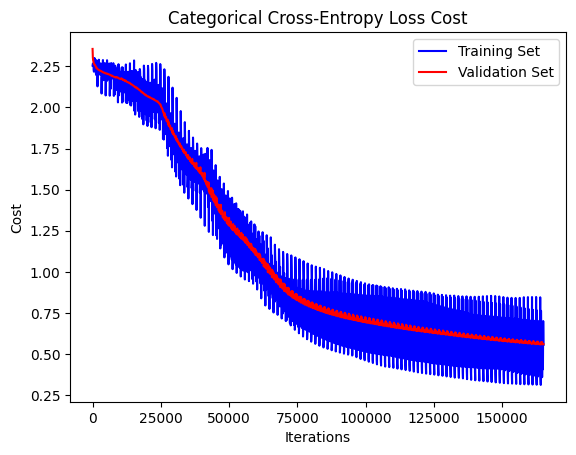

Time: 293.9078781604767
Test accuracy:
0.8438


In [39]:
(train_X, train_y), (test_X, test_Y) = mnist.load_data()
train_X, test_X, train_y, test_Y = preprocess_data(train_X, test_X, train_y, test_Y)
#batch_size(train_X, test_X, train_y, test_Y, use_batchnorm=False, seed=2)
Neural_Network(train_X, test_X, train_y, test_Y, use_batchnorm=False,seed=2)

## **Section 5:**

Iterations: 16200
Epochs: 22

Train accuracy:
0.8808958333333333

Validation accuracy:
0.8824166666666666



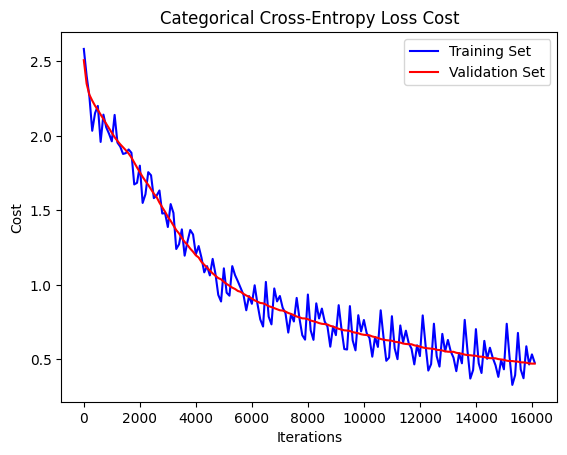

Time: 33.402567625045776
Test accuracy:
0.8834


In [40]:
(train_X, train_y), (test_X, test_Y) = mnist.load_data()
train_X, test_X, train_y, test_Y = preprocess_data(train_X, test_X, train_y, test_Y)
Neural_Network(train_X, test_X, train_y, test_Y, use_batchnorm=True,seed=2)

## **Section 6:**

Iterations: 128000
Epochs: 171

Train accuracy:
0.945375

Validation accuracy:
0.9313333333333333



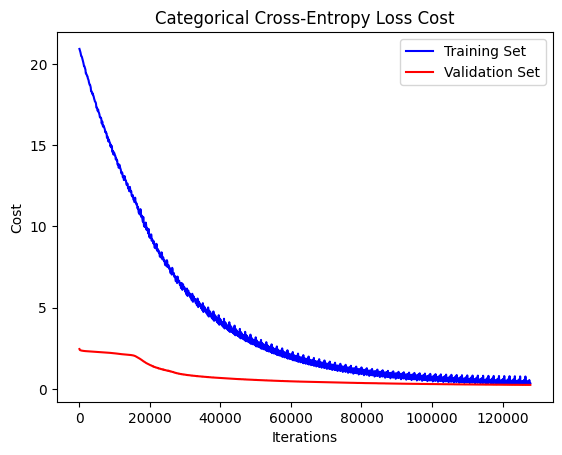

Time: 232.2473976612091
Test accuracy:
0.9363


In [44]:
(train_X, train_y), (test_X, test_Y) = mnist.load_data()
train_X, test_X, train_y, test_Y = preprocess_data(train_X, test_X, train_y, test_Y)
Neural_Network(train_X, test_X, train_y, test_Y, use_batchnorm=False,seed=2,r=0.15)

Iterations: 225000
Epochs: 300

Train accuracy:
0.9254583333333334

Validation accuracy:
0.9236666666666666



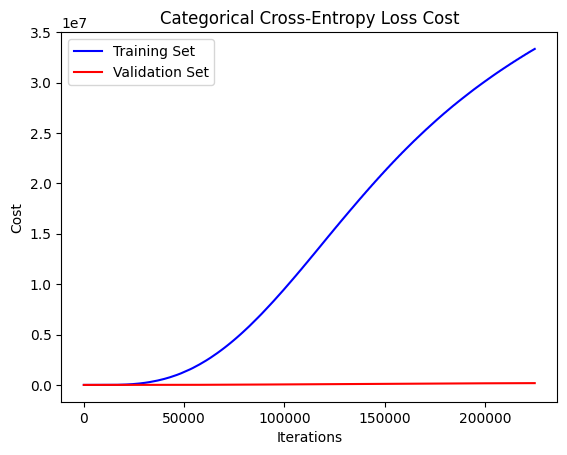

Time: 464.0103425979614
Test accuracy:
0.9199


In [45]:
(train_X, train_y), (test_X, test_Y) = mnist.load_data()
train_X, test_X, train_y, test_Y = preprocess_data(train_X, test_X, train_y, test_Y)
Neural_Network(train_X, test_X, train_y, test_Y, use_batchnorm=True,seed=2,r=0.15)

##**Compare weights:**

Iterations: 225000
Epochs: 300

Train accuracy:
0.81175

Validation accuracy:
0.8071666666666667



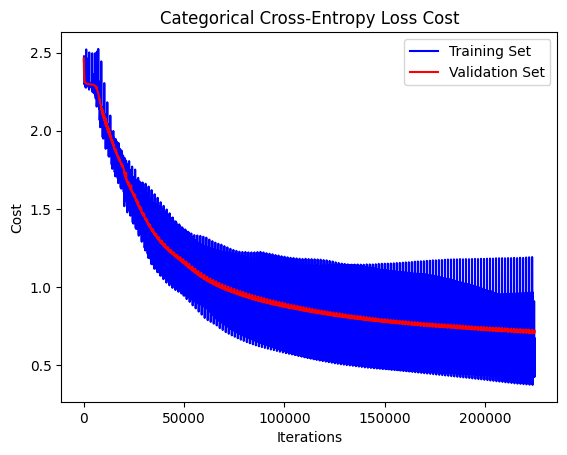

Iterations: 55600
Epochs: 75

Train accuracy:
0.8777916666666666

Validation accuracy:
0.8734166666666666



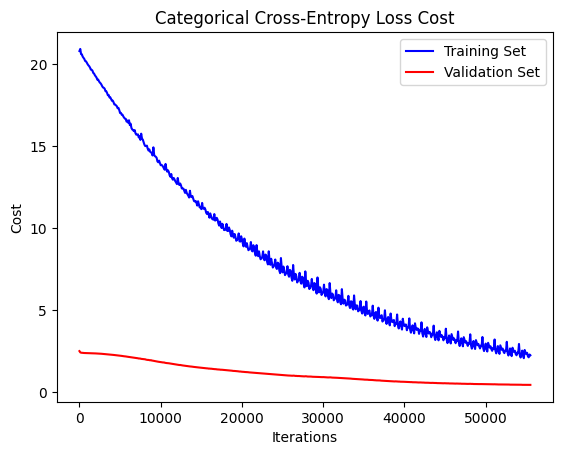

In [46]:
(train_X, train_y), (test_X, test_Y) = mnist.load_data()
train_X, test_X, train_y, test_Y = preprocess_data(train_X, test_X, train_y, test_Y)
normal_params, costs = L_layer_model(train_X, train_y, [20, 7, 5, 10], 0.009, 300, 64, False, r=0)
l2_params, costs = L_layer_model(train_X, train_y, [20, 7, 5, 10], 0.009, 300, 64, False, r=0.15)

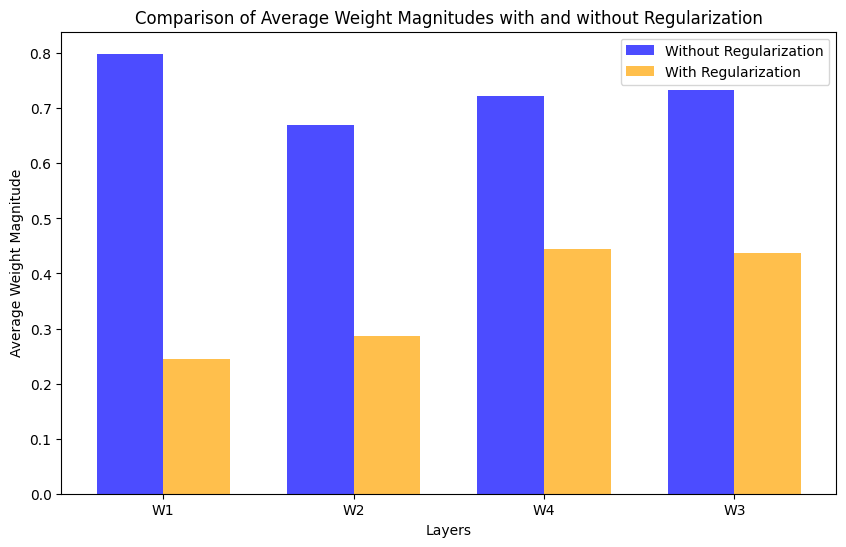

In [81]:
import matplotlib.pyplot as plt

def average_weight_magnitude(params):
    """
    Calculate the average absolute value of weights for each layer.
    """
    layer_names = list(params.keys())
    avg_magnitudes = []

    for layer_name in layer_names:
       if layer_name.startswith('W'):
          weights = params[layer_name]
          avg_magnitude = np.mean(np.abs(weights))
          avg_magnitudes.append(avg_magnitude)

    return avg_magnitudes

def compare_average_weights(params_without_reg, params_with_reg):
    avg_magnitudes_without_reg = average_weight_magnitude(params_without_reg)
    avg_magnitudes_with_reg = average_weight_magnitude(params_with_reg)

    # Use common layer names
    common_layer_names = set(params_without_reg.keys())
    common_layer_names = [name for name in common_layer_names if name.startswith('W')]

    # Bar plot
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(common_layer_names))

    plt.bar(index, avg_magnitudes_without_reg, bar_width, label='Without Regularization', color='blue', alpha=0.7)
    plt.bar(index + bar_width, avg_magnitudes_with_reg, bar_width, label='With Regularization', color='orange', alpha=0.7)

    plt.xlabel('Layers')
    plt.ylabel('Average Weight Magnitude')
    plt.title('Comparison of Average Weight Magnitudes with and without Regularization')
    plt.xticks(index + bar_width / 2, common_layer_names)
    plt.legend()
    plt.show()

# Compare average weights
compare_average_weights(normal_params, l2_params)
